In [1]:
from transformers import pipeline
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DebertaV2Tokenizer

2024-12-30 14:32:23.983453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sofiepalmuskronborg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
data = pd.read_csv("csv files/filtered_data.csv", index_col=0)  # 459.728 entries
unique_ads = data.drop_duplicates(
    subset=["ad_creative_body"]
)  # # print(unique_txt.size) 58.449 unique ad text bites to proces

NameError: name 'pd' is not defined

## checking the length of tokens from the dataframe

In [47]:
# Load the tokenizer for DebertaV2
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")

max_length = 512  # max length of text/tokes for DeBERTa

above_limit = 0
below_limit = 0
more_than_double = 0
double_above_limit = 0
triple_above_limit = 0

for text in unique_ads["ad_creative_body"]:
    tokens = tokenizer.encode(
        text, add_special_tokens=True
    )  # Tokenize the ad text using DebertaV2
    token_length = len(tokens)

    if token_length > max_length:
        above_limit += 1
        if token_length >= 1536 and token_length < 2047:
            triple_above_limit += 1
        if token_length >= 1024 and token_length <= 1536:
            double_above_limit += 1
        if token_length <= 1024:
            more_than_double +=1
    else:
        below_limit += 1

In [48]:
print(f"Amount of ads within the limit: {below_limit}")
print(f"Amount of ads above the limit: {above_limit}")
print(f"Ads above the limit but below 1024 tokens: {more_than_double}") # split with 2
print(f"Ads above 1024 tokens but below 1536 tokens: {double_above_limit}")  # split with 3
print(f"Ads above 1536 tokens but below 2047 tokens: {triple_above_limit}")  # split with 4


Amount of ads within the limit: 58381
Amount of ads above the limit: 68
Ads above the limit but below 1024 tokens: 60
Ads above 1024 tokens but below 1536 tokens: 5
Ads above 1536 tokens but below 2047 tokens: 3


## Running the ads through DeBERTa

In [14]:
zeroshot_classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33",
)

In [15]:
hypothesis_template = "This ad is about {}"
classes_verbalized = [
    "Economy",
    "Civil Rights",
    "Healthcare",
    "Agriculture",
    "Labor and Employment",
    "Education and Culture",
    "Climate",
    "Immigration",
    "Transport",
    "Law and Crime",
    "Social Welfare",
    "Housing",
    "Defense",
    "Foreign Affair",
    "Call for Action",
    "Other"   #placeholder category
] 

In [56]:
# list to store the number of tokens for each ad
num_tokens_list = []

# Tokenize each ad_creative_body and get the number of tokens
for text in unique_ads["ad_creative_body"]:
    tokens = tokenizer.encode(text, add_special_tokens=False)  # Tokenize the text
    num_tokens_list.append(len(tokens)) 

unique_ads["num_tokens"] = num_tokens_list # make new column with the token count for each ad

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_968/3584049382.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_ads["num_tokens"] = num_tokens_list


In [ ]:
# Split into two df based on limitation
below_limit = unique_ads[unique_ads["num_tokens"] <= 512]
above_limit = unique_ads[unique_ads["num_tokens"] > 512]

# below_limit.to_csv("under_512.csv")
# above_limit.to_csv("aboev_512.csv")

## processing text below the limit

In [52]:
# Process ads within limit
text_to_vector_below = {}
for text in below_limit["ad_creative_body"]:
    output = zeroshot_classifier(
        text,
        classes_verbalized,
        hypothesis_template=hypothesis_template,
        multi_label=False,
    )
    text_to_vector_below[text] = {
        "labels": output["labels"],
        "scores": output["scores"],
    }

# Making two new columns
below_limit["labels"] = below_limit["ad_creative_body"].map(
    lambda text: text_to_vector_below[text]["labels"]
)
below_limit["scores"] = below_limit["ad_creative_body"].map(
    lambda text: text_to_vector_below[text]["scores"]
)

## processing text above limit (complicated one)

In [ ]:
text_to_vector_above = (
    {}
)  # dict to store labels + scores for each ad abover # 512 tokens

for text in above_limit["ad_creative_body"]:

    total_scores = []  # list to keep scres for each split
    all_labels = None  # will store labels

    tokens = tokenizer.encode(text, add_special_tokens=True)

    total_splits = (  # figure out how many splits in terms of max l
        len(tokens) + max_length - 1
    ) // max_length  # // rounding to a single int value

    split_size = (  # figure out how to do an equal split on the total tokens (as equal as possible)
        len(tokens) + total_splits - 1
    ) // total_splits  # // rounding to a single int value

    for i in range(0, len(tokens), split_size):
        chunk = tokens[i : i + split_size]
        chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)

        output = zeroshot_classifier(
            chunk_text,
            classes_verbalized,
            hypothesis_template=hypothesis_template,
            multi_label=False,
        )

        # gather the scores
        if all_labels is None:
            all_labels = output["labels"]  # store labels on first text bit
        total_scores.append(output["scores"])  # Collect all scores for avg

    # Average the scores across all chunks
    avg_scores = [sum(s) / len(total_scores) for s in zip(*total_scores)]

    text_to_vector_above[text] = {
        "labels": all_labels,  # Use the labels from run throough of the text bit
        "scores": avg_scores,
    }

# 2 new columns
above_limit["labels"] = above_limit["ad_creative_body"].map(
    lambda text: text_to_vector_above[text]["labels"]
)
above_limit["scores"] = above_limit["ad_creative_body"].map(
    lambda text: text_to_vector_above[text]["scores"]
)

## store results from both dataframes back to org DataFrame


In [ ]:
# putting dataframes together so all data is gathere
vertical_concat = pd.concat([below_limit, above_limit], axis=0)

In [ ]:
# merging the additional rows back into origianl df (filtered_data) based on ad text
additional_rows = vertical_concat[
    ["ad_creative_body", "labels", "scores", "top_label", "top_score"]
]

data_merged = pd.merge(data, additional_rows, on="ad_creative_body", how="left")

In [ ]:
# checking the numbers er ok
# sort away duplicate ad texts coming from the same politician -> 58.574
label_data_unique = data_merged.drop_duplicates(subset=["ad_creative_body", "page_id"])

# sort away duplicate text in general -> 58.449 rows ^ 125 duplicate texts when comparing
label_data_unique = data_merged.drop_duplicates(["ad_creative_body"])

## saving top label + its score

In [ ]:
data_merged["labels"] = data_merged["labels"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
data_merged["scores"] = data_merged["scores"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Retrieving first instance in each column
data_merged["top_label"] = data_merged["labels"].str[0]
data_merged["top_score"] = data_merged["scores"].str[0]

In [ ]:
top_labels = (data_merged["top_label"].value_counts()).iloc[:18]  # all labels

# calcu the amount + % for each top
top_percentages = (
    data_merged["top_label"].value_counts(normalize=True).iloc[:18]
) * 100

# Print the counts and percentages in a readable format
print("Stats on top labels:\n")
for label, count, percentage in zip(
    top_labels.index, top_labels.values, top_percentages.values
):
    print(f"{label}: {count} ads ({percentage:.2f}%)")

Stats on top labels:

Call for Action: 353488 ads (76.89%)
Healthcare: 20754 ads (4.51%)
Law and Crime: 17701 ads (3.85%)
Economy: 10691 ads (2.33%)
Climate: 10426 ads (2.27%)
Immigration: 9408 ads (2.05%)
Defense: 8676 ads (1.89%)
Other: 6747 ads (1.47%)
Education and Culture: 5048 ads (1.10%)
Labor and Employment: 4585 ads (1.00%)
Foreign Affair: 4035 ads (0.88%)
Civil Rights: 3213 ads (0.70%)
Agriculture: 1555 ads (0.34%)
Housing: 1192 ads (0.26%)
Transport: 1135 ads (0.25%)
Social Welfare: 1074 ads (0.23%)


In [ ]:
data_merged = data_merged.drop(["uncorrelated_entropy", "real_entropy"], axis=1)

In [ ]:
data_merged.to_csv("labeled_ads.csv")

## example for report

In [ ]:
zeroshot_classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33",
)

In [ ]:
hypothesis_template = "This ad is about {}"
classes_verbalized = [
    "Economy",
    "Civil Rights",
    "Healthcare",
    "Agriculture",
    "Labor and Employment",
    "Education and Culture",
    "Climate",
    "Immigration",
    "Transport",
    "Law and Crime",
    "Social Welfare",
    "Housing",
    "Defense",
    "Foreign Affair",
    "Call for Action",
    "Other",  # placeholder category
]

In [10]:
from transformers import pipeline

text = "Support the Democrats in the battle against climate change!"
hypothesis_template = " This ad is about {}"
classes_verbalized = ["Immigration", "Defense", "Climate", "Healthcare"]

zeroshot_classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33",
)

zeroshot_classifier(text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False,)

# output: 'labels': ['Climate', 'Defense', 'Immigration', 'Healthcare'],
#         'scores': [0.9989873766899109, 0.0006069607916288078, 0.00020502437837421894, 0.00020061143732164055]



{'sequence': 'Support the Democrats in the battle against climate change!',
 'labels': ['Climate', 'Defense', 'Immigration', 'Healthcare'],
 'scores': [0.9989873766899109,
  0.0006069607916288078,
  0.00020502437837421894,
  0.00020061143732164055]}

## token length

In [28]:
data = pd.read_csv(
    "/Users/sofiepalmuskronborg/Desktop/Thesis/csv files/filtered_data.csv", index_col=0
)  # 459.728 entries
unique_ads = data.drop_duplicates(subset=["ad_creative_body"])

df_d = data[
    data["party"] == "Democrat"
]  # all ads because that is what entropy is calculated based on
df_r = data[data["party"] == "Republican"]
# df_un_d = unique_ads[unique_ads["party"] == "Democrat"]
# df_un_r = unique_ads[unique_ads["party"] == "Republican"]

In [4]:
df_d = unique_ads[
    unique_ads["party"] == "Democrat"
]  # all ads because that is what entropy is calculated based on
df_r = unique_ads[unique_ads["party"] == "Republican"]

In [29]:
# re-load the tokenizer for DebertaV2
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")

lenght_d = []
lenght_r = []

for text in df_d["ad_creative_body"]: #democrats
    tokens = tokenizer.encode(text, add_special_tokens=True)  # tokenize the ad text
    lenght_d.append(len(tokens)) 

for text in df_r["ad_creative_body"]: #republicans
    tokens = tokenizer.encode(text, add_special_tokens=True)  # tokenize the ad text
    lenght_r.append(len(tokens))  

df_d["token length"] = lenght_d  # Add token lengths for Democrats
df_r["token length"] = lenght_r  # Add token lengths for Republicans

/Users/sofiepalmuskronborg/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1564/1850464356.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d["token length"] = lenght_d  # Add token lengths for Democrats
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1564/1850464356.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [5]:
# Calculate summary statistics for token lengths for each party
party_token_summary_d = df_d["token length"].describe()
party_token_summary_r = df_r["token length"].describe()

print("Democrats token length:\n", party_token_summary_d)
print("\nRepublicans token length:\n", party_token_summary_r)

Democrats token length:
 count    35530.000000
mean        77.354574
std         55.187371
min          3.000000
25%         44.000000
50%         64.000000
75%         92.000000
max       1227.000000
Name: token length, dtype: float64

Republicans token length:
 count    22919.000000
mean        55.724072
std         57.199663
min          3.000000
25%         29.000000
50%         43.000000
75%         63.000000
max       1971.000000
Name: token length, dtype: float64


## ad length

In [42]:
word_count_d = []
word_count_r = []

for text in df_d["ad_creative_body"]: #democrat
    word_count = len(text.split())  
    word_count_d.append(word_count)  

for text in df_r["ad_creative_body"]:
    word_count = len(text.split())  # republican
    word_count_r.append(word_count)  

df_d["ad length"] = word_count_d 
df_r["ad length"] = word_count_r

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_28197/3758588448.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d["ad length"] = word_count_d
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_28197/3758588448.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r["ad length"] = word_count_r


In [43]:
# stats for token lengths for each party
party_token_summary_d = df_d["ad length"].describe()
party_token_summary_r = df_r["ad length"].describe()

print("Democrats ad word stats:\n", party_token_summary_d)
print("\nRepublicans ad word stats:\n", party_token_summary_r)

Democrats ad word stats:
 count    35530.00000
mean        58.47830
std         42.56216
min          1.00000
25%         33.00000
50%         48.00000
75%         70.00000
max       1098.00000
Name: ad length, dtype: float64

Republicans ad word stats:
 count    22919.000000
mean        41.994502
std         45.619241
min          1.000000
25%         22.000000
50%         33.000000
75%         47.000000
max       1642.000000
Name: ad length, dtype: float64


In [30]:
import numpy as np
values_d, bins = np.histogram(df_d["token length"], bins=np.linspace(0, 500, 30))
values_d = values_d / sum(values_d)

values_r, bins = np.histogram(df_r["token length"], bins=bins)
values_r = values_r / sum(values_r)

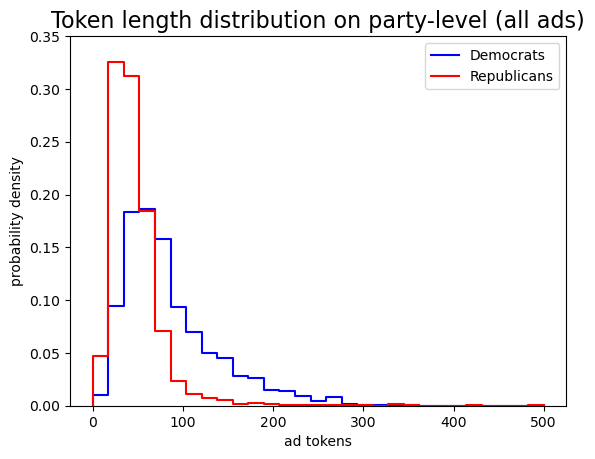

In [31]:
# Ensure correct alignment for step plot
bins_step = bins  # Use all bin edges
values_d_step = np.concatenate(
    [[0], values_d]
)  # Add a zero at the start for the first bin
values_r_step = np.concatenate([[0], values_r])  # Same for Republicans

plt.step(
    bins_step,
    values_d_step,
    where="pre",
    # width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
)

plt.step(
    bins_step,
    values_r_step,
    where="pre",
    # width=bins[1] - bins[0],
    label="Republicans",
    color="red",
)

plt.title("Token length distribution on party-level (all ads)", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("ad tokens")
plt.ylim(0.0, 0.35)
plt.show()

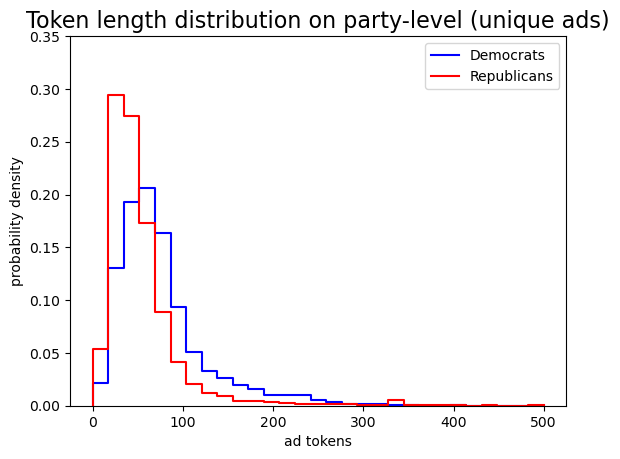

In [27]:
bins_step = bins 
values_d_step = np.concatenate(
    [[0], values_d]
)  # Add a zero at the start for the first bin
values_r_step = np.concatenate([[0], values_r]) 

plt.step(
    bins_step,
    values_d_step,
    where= "pre",
    # width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
)

plt.step(
    bins_step,
    values_r_step,
    where="pre",
    # width=bins[1] - bins[0],
    label="Republicans",
    color="red",
)

plt.title("Token length distribution on party-level (unique ads)", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("ad tokens")
plt.ylim(0.0, 0.35)
plt.show()